In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr


img = cv2.imread('sar_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 



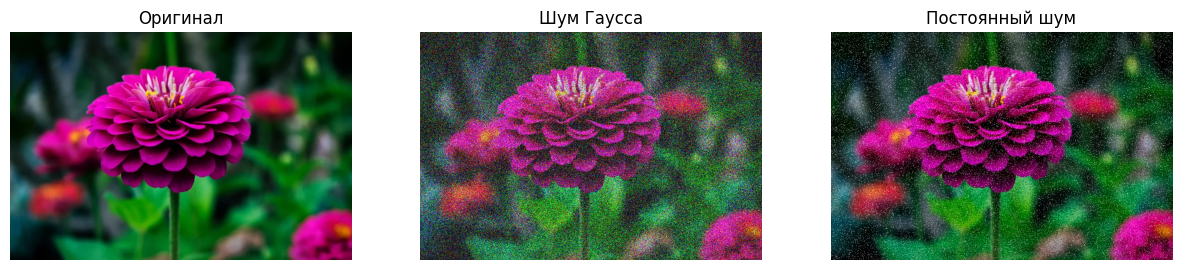

In [2]:
# Гауссовский шум
def gauss_noise(image, sigma=100):
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

# Постоянный шум 
def salt_pepper_noise(image, salt=0.05, pepper=0.05):
    noisy = image.copy()
    total_pixels = image.size // 3
    # соль
    num_salt = int(total_pixels * salt)
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 255
    # перец
    num_pepper = int(total_pixels * pepper)
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy[coords[0], coords[1], :] = 0
    return noisy

gauss_img = gauss_noise(img, sigma=100)
sp_img = salt_pepper_noise(img, salt=0.05, pepper=0.05)


plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Оригинал')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gauss_img)
plt.title('Шум Гаусса')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sp_img)
plt.title('Постоянный шум')
plt.axis('off')

plt.show()

In [3]:
def apply_all_filters(noisy_img):
    filters = {}
    
    # Медианный фильтр
    filters['Медианный 3×3'] = cv2.medianBlur(noisy_img, 3)
    filters['Медианный 5×5'] = cv2.medianBlur(noisy_img, 5)
    filters['Медианный 7×7'] = cv2.medianBlur(noisy_img, 7)
    
    # Фильтр Гаусса
    filters['Гаусс 3×3'] = cv2.GaussianBlur(noisy_img, (3,3), 0)
    filters['Гаусс 5×5'] = cv2.GaussianBlur(noisy_img, (5,5), 1)
    filters['Гаусс 7×7'] = cv2.GaussianBlur(noisy_img, (7,7), 2)
    
    # Билатеральный фильтр
    filters['Билатеральный (d=9, цвет=75)'] = cv2.bilateralFilter(noisy_img, 9, 75, 75)
    filters['Билатеральный (d=15, цвет=100)'] = cv2.bilateralFilter(noisy_img, 15, 100, 100)
    filters['Билатеральный (d=15, цвет=150)'] = cv2.bilateralFilter(noisy_img, 15, 150, 150)
    
    # Нелокальные средние
    filters['Нелокальные средние (сила 10)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 10, 10, 7, 21)
    filters['Нелокальные средние (сила 20)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 20, 20, 7, 21)
    filters['Нелокальные средние (сила 30)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 30, 30, 7, 21)
    
    return filters


gauss_filters = apply_all_filters(gauss_img)
sp_filters = apply_all_filters(sp_img)

In [4]:
def get_top5(original, filters_dict):
    results = []
    for name, filtered in filters_dict.items():
        p = psnr(original, filtered)
        s = ssim(original, filtered, channel_axis=-1)  # для цветного
        results.append((name, p, s, filtered))
    
    results.sort(key=lambda x: x[1], reverse=True)
    return results[:5]

# Для шума Гаусса
print("ТОП-5 ДЛЯ ШУМА ГАУССА")
top_gauss = get_top5(img, gauss_filters)
for i, (name, p, s, _) in enumerate(top_gauss, 1):
    print(f"{i}. {name} → PSNR: {p:.2f} дБ, SSIM: {s:.4f}")

print("\nТОП-5 ДЛЯ ПОСТОЯННОГО ШУМА")
top_sp = get_top5(img, sp_filters)
for i, (name, p, s, _) in enumerate(top_sp, 1):
    print(f"{i}. {name} → PSNR: {p:.2f} дБ, SSIM: {s:.4f}")

ТОП-5 ДЛЯ ШУМА ГАУССА
1. Медианный 7×7 → PSNR: 23.39 дБ, SSIM: 0.3775
2. Медианный 5×5 → PSNR: 21.03 дБ, SSIM: 0.2429
3. Гаусс 7×7 → PSNR: 18.94 дБ, SSIM: 0.3879
4. Гаусс 5×5 → PSNR: 17.78 дБ, SSIM: 0.1878
5. Билатеральный (d=15, цвет=150) → PSNR: 17.34 дБ, SSIM: 0.1118

ТОП-5 ДЛЯ ПОСТОЯННОГО ШУМА
1. Медианный 3×3 → PSNR: 40.47 дБ, SSIM: 0.9851
2. Медианный 5×5 → PSNR: 38.98 дБ, SSIM: 0.9730
3. Медианный 7×7 → PSNR: 36.38 дБ, SSIM: 0.9584
4. Гаусс 7×7 → PSNR: 26.24 дБ, SSIM: 0.6174
5. Нелокальные средние (сила 30) → PSNR: 24.18 дБ, SSIM: 0.6452


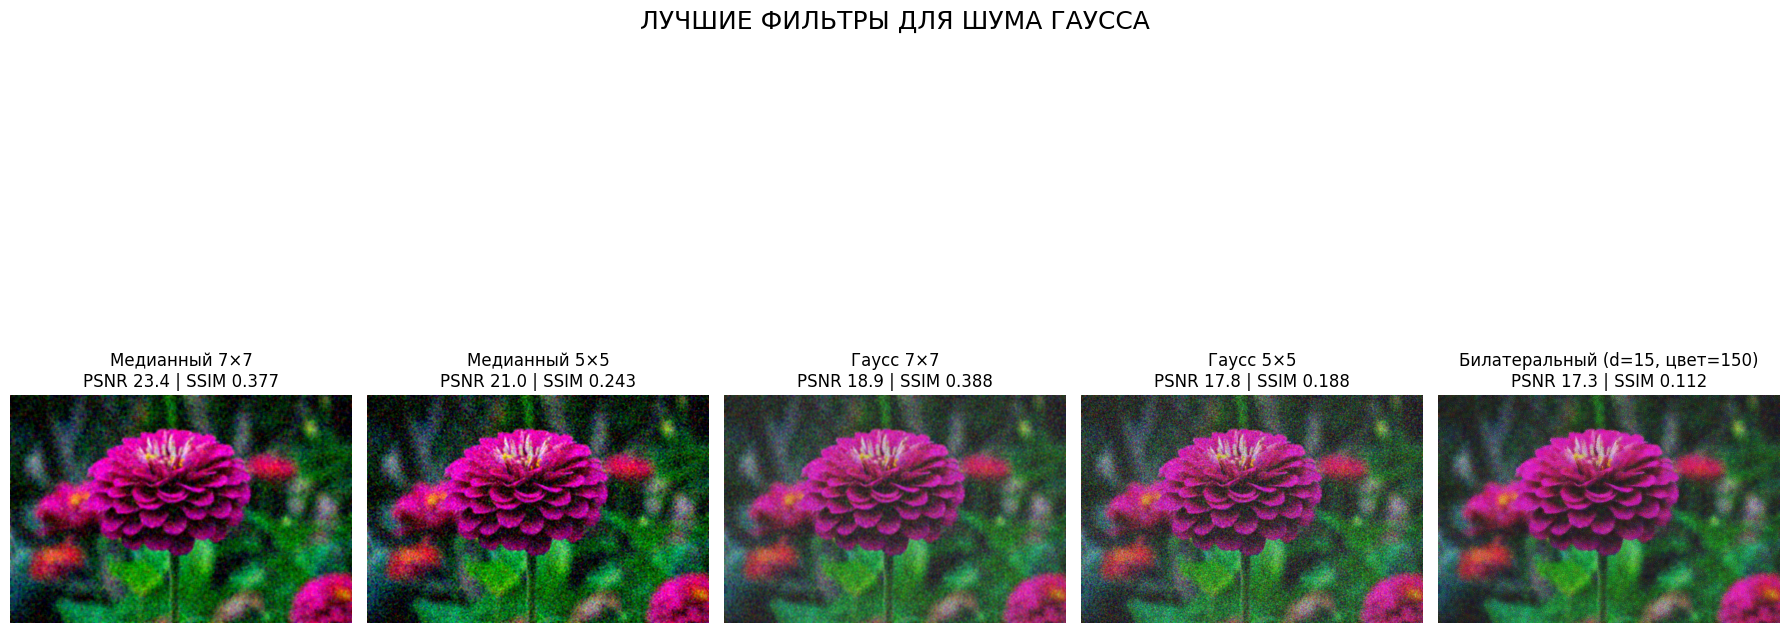

In [5]:
plt.figure(figsize=(18,10))
plt.suptitle('ЛУЧШИЕ ФИЛЬТРЫ ДЛЯ ШУМА ГАУССА', fontsize=18, y=0.98)

for i, (name, p, s, filtered) in enumerate(top_gauss, 1):
    plt.subplot(1, 5, i)
    plt.imshow(filtered)
    plt.title(f'{name}\nPSNR {p:.1f} | SSIM {s:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

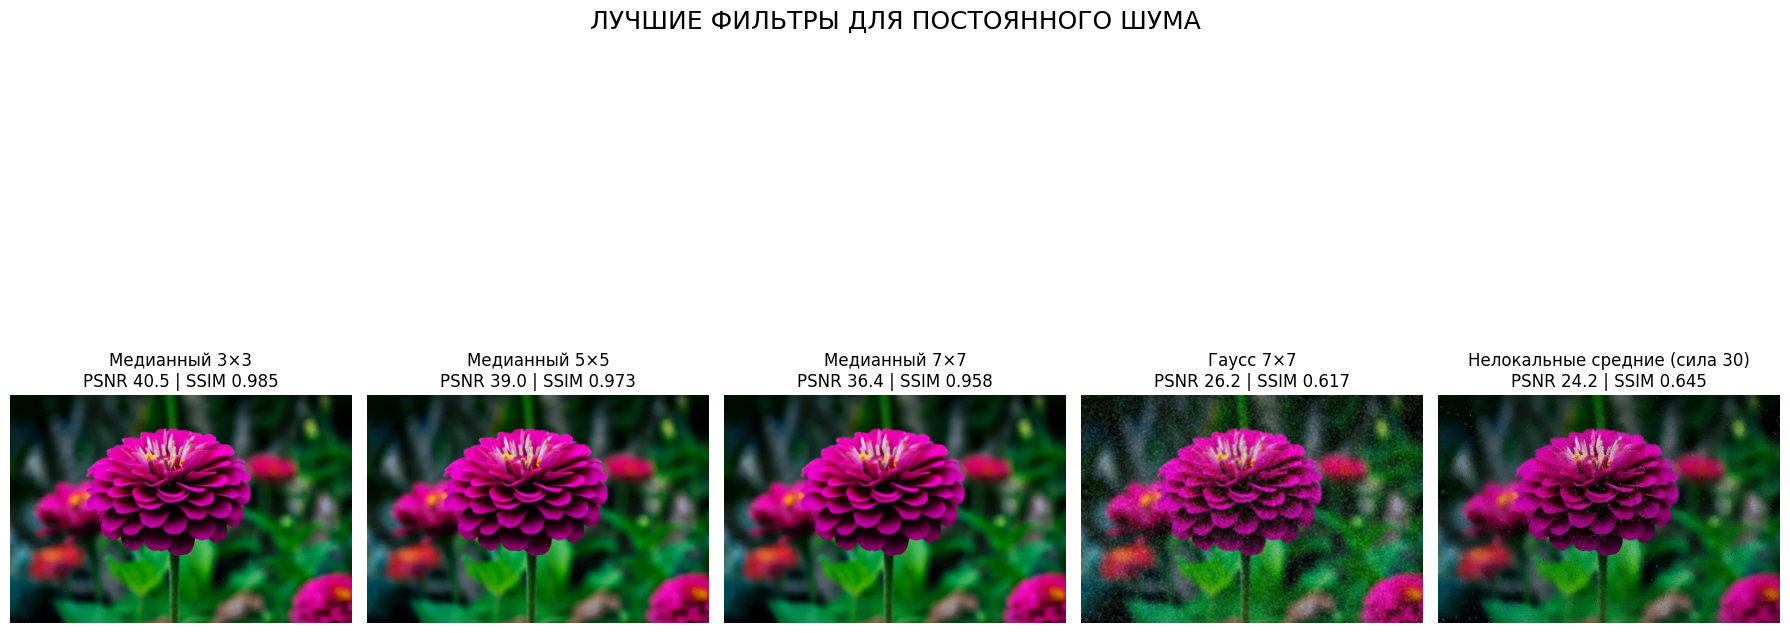

In [6]:
plt.figure(figsize=(18,10))
plt.suptitle('ЛУЧШИЕ ФИЛЬТРЫ ДЛЯ ПОСТОЯННОГО ШУМА', fontsize=18, y=0.98)

for i, (name, p, s, filtered) in enumerate(top_sp, 1):
    plt.subplot(1, 5, i)
    plt.imshow(filtered)
    plt.title(f'{name}\nPSNR {p:.1f} | SSIM {s:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()